In [ ]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.5.1+cu121


In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  torch_version = str(torch.__version__)
  scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  !pip install torch-scatter -f $scatter_src
  !pip install torch-sparse -f $sparse_src
  !pip install torch-geometric
  !pip install ogb

Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 65.2 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 1.9 MB/s eta 0:00:00


In [ ]:
# set a seed so that we can directly monitor our discrete model changes
import random
import numpy as np
import torch

SEED = 2
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

Graph Structuring

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data

# load the preprocessed datasets
players_data = pd.read_csv('/content/players_preprocessed_cleaned.csv')
teams_data = pd.read_csv('/content/teams_preprocessed.csv')

# encode the positions as integers
position_encoder = LabelEncoder()
players_data['Pos'] = position_encoder.fit_transform(players_data['Pos'])

player_nodes = {}
team_nodes = {}
player_to_team_edges = []
player_to_player_edges = []

# extract player nodes, and name them "player_year"
for _, row in players_data.iterrows():
  player_key = f"{row['Player']}_{row['Year']}"
  player_nodes[player_key] = {
      'Born': row['Born'],
      'Pos': row['Pos'],  # Encoded as integer
      'Market_Value_Euro': row['Market_Value_Euro']
      }

# extract team nodes, and name them "team_year"
for _, row in teams_data.iterrows():
  team_key = f"{row['Squad']}_{row['Year']}"
  team_nodes[team_key] = {key: row[key] for key in teams_data.columns if key not in ['Year', 'Squad']}

# create the player-to-team edges
for _, row in players_data.iterrows():
  player_key = f"{row['Player']}_{row['Year']}"
  team_key = f"{row['Squad']}_{row['Year']}"
  if player_key in player_nodes and team_key in team_nodes:
      edge_features = {key: row[key] for key in [
          'Gls', 'Ast', 'G_plus_A', 'G_minus_PK', 'PK', 'PKatt',
          'CrdY', 'CrdR', 'xG_Expected', 'npxG_Expected', 'xAG_Expected',
          'npxG_plus_xAG_Expected', 'PrgC_Progression', 'PrgP_Progression',
          'Gls_Per_90', 'Ast_Per_90', 'G_plus_A_Per_90', 'G_minus_PK_Per_90',
          'G_plus_A_minus_PK_Per_90', 'xG_Per_90', 'xAG_Per_90',
          'xG_plus_xAG_Per_90', 'npxG_Per_90', 'npxG_plus_xAG_Per_90'
      ]}
      player_to_team_edges.append((player_key, team_key, edge_features))

# create the player-to-player edges
player_grouped = players_data.groupby('Player')
for player, group in player_grouped:
  group_sorted = group.sort_values(by='Year')
  for i in range(len(group_sorted) - 1):
      curr_row = group_sorted.iloc[i]
      next_row = group_sorted.iloc[i + 1]

      curr_player_key = f"{curr_row['Player']}_{curr_row['Year']}"
      next_player_key = f"{next_row['Player']}_{next_row['Year']}"

      if curr_player_key in player_nodes and next_player_key in player_nodes:
          edge_features = {
              key: next_row[key] - curr_row[key]
              for key in [
                  'Gls', 'Ast', 'G_plus_A', 'G_minus_PK', 'PK', 'PKatt',
                  'CrdY', 'CrdR', 'xG_Expected', 'npxG_Expected', 'xAG_Expected',
                  'npxG_plus_xAG_Expected', 'PrgC_Progression', 'PrgP_Progression',
                  'Gls_Per_90', 'Ast_Per_90', 'G_plus_A_Per_90', 'G_minus_PK_Per_90',
                  'G_plus_A_minus_PK_Per_90', 'xG_Per_90', 'xAG_Per_90',
                  'xG_plus_xAG_Per_90', 'npxG_Per_90', 'npxG_plus_xAG_Per_90'
              ]
          }
          player_to_player_edges.append((curr_player_key, next_player_key, edge_features))

# assign unique IDs to nodes
node_to_id = {node: i for i, node in enumerate(list(player_nodes.keys()) + list(team_nodes.keys()))}

edge_index = []
edge_attr = []

# add the player-to-team edges
for player_key, team_key, features in player_to_team_edges:
  edge_index.append([node_to_id[player_key], node_to_id[team_key]])
  edge_attr.append(list(features.values()))

# add the player-to-player edges
for curr_player_key, next_player_key, features in player_to_player_edges:
  edge_index.append([node_to_id[curr_player_key], node_to_id[next_player_key]])
  edge_attr.append(list(features.values()))

# convert to PyTorch Geometric tensors
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

# combine all features for nodes
all_features = []
for node in node_to_id.keys():
  if node in player_nodes:
    player_features = player_nodes[node]
    # this pads the back end of player node features with zeros
    all_features.append([
        player_features['Born'],
        player_features['Market_Value_Euro'],
        player_features['Pos']
    ] + [0] * len(next(iter(team_nodes.values()))))
  elif node in team_nodes:
    team_features = team_nodes[node]
    # this pads the front end of team node features with zeros
    all_features.append([0, 0, 0] + list(team_features.values()))

node_features = torch.tensor(all_features, dtype=torch.float)

# create PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

print(data)


Data(x=[2044, 33], edge_index=[2, 3307], edge_attr=[3307, 24])


2-layer GraphSAGE without Dropout

Epoch: 0, Train Loss: 78163216.0000,Val Loss: 101602456.0000, Test Loss: 94577432.0000
Epoch: 10, Train Loss: 70548824.0000,Val Loss: 91572704.0000, Test Loss: 85633296.0000
Epoch: 20, Train Loss: 59213880.0000,Val Loss: 73738872.0000, Test Loss: 75200368.0000
Epoch: 30, Train Loss: 48776208.0000,Val Loss: 63894492.0000, Test Loss: 67890688.0000
Epoch: 40, Train Loss: 36051180.0000,Val Loss: 53255664.0000, Test Loss: 58514648.0000
Epoch: 50, Train Loss: 28274038.0000,Val Loss: 45880844.0000, Test Loss: 51577236.0000
Epoch: 60, Train Loss: 23871870.0000,Val Loss: 41187440.0000, Test Loss: 44762800.0000
Epoch: 70, Train Loss: 18258360.0000,Val Loss: 26448876.0000, Test Loss: 28529794.0000
Epoch: 80, Train Loss: 13280481.0000,Val Loss: 15897991.0000, Test Loss: 21802378.0000
Epoch: 90, Train Loss: 7911375.0000,Val Loss: 10233487.0000, Test Loss: 9486841.0000
Epoch: 100, Train Loss: 2765482.7500,Val Loss: 3168495.5000, Test Loss: 3873777.7500
Epoch: 110, Train Loss: 120663.5000,Val Loss: 1

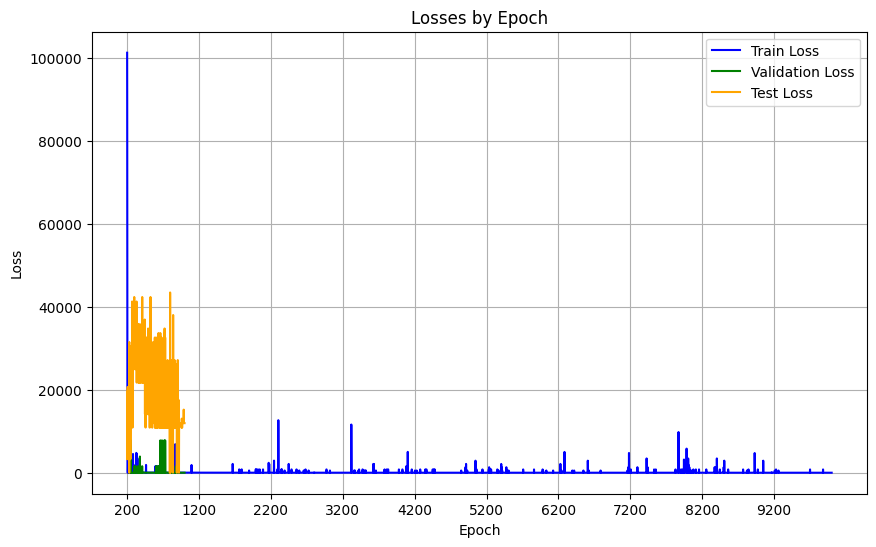

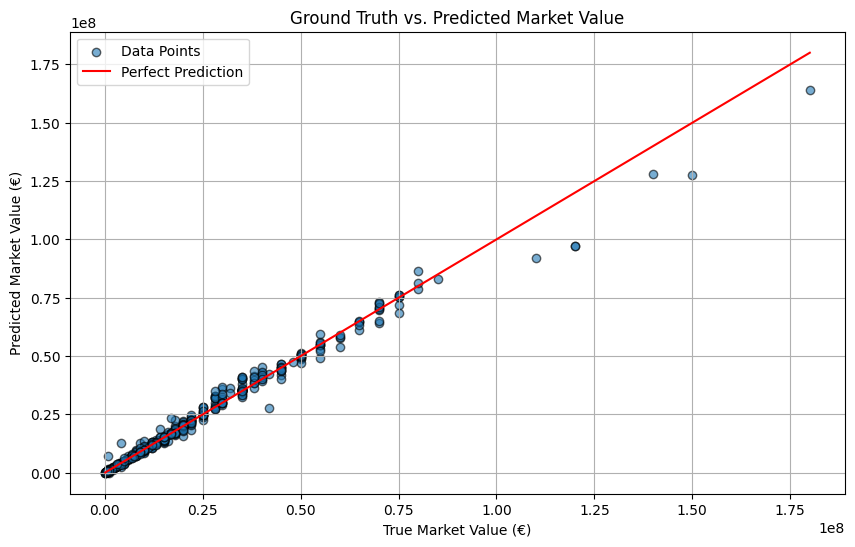

In [ ]:
import pandas as pd
import torch
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

# defines the GraphSAGE model
class GraphSAGE(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super(GraphSAGE, self).__init__()
    torch.manual_seed(SEED)
    self.conv1 = SAGEConv(in_channels, hidden_channels)
    self.conv2 = SAGEConv(hidden_channels, out_channels)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = F.relu(x)

    x = self.conv2(x, edge_index)
    x = F.relu(x)  # Ensure non-negative outputs

    return x

# normalize input features
data.x = (data.x - data.x.mean(dim=0)) / data.x.std(dim=0)

# set up data.y for regression; initialize with zeros
data.y = torch.zeros(data.x.size(0))

# utilize Market_Value_Euro from player nodes only (team nodes will have values of zero)
for node_name, node_id in node_to_id.items():
  if node_name in player_nodes and 'Market_Value_Euro' in player_nodes[node_name]:
    market_value = player_nodes[node_name]['Market_Value_Euro']
    if market_value > 0:
      data.y[node_id] = market_value

# scale target values to [0, 1]
data.y_max = data.y.max()
data.y = data.y / data.y_max

# extract years from node names for training and testing masks
val_year = 2023
test_year = 2024
data.train_mask = torch.zeros(data.x.size(0), dtype=torch.bool)
data.val_mask = torch.zeros(data.x.size(0), dtype=torch.bool)
data.test_mask = torch.zeros(data.x.size(0), dtype=torch.bool)

for node_name, node_id in node_to_id.items():
  # checks to make sure the node is a player node with a valid Market_Value_Euro value
  if node_name in player_nodes and 'Market_Value_Euro' in player_nodes[node_name]:
    year = int(node_name.split("_")[-1])
    # places 2023 nodes in the val set, 2024 nodes in the test set, all others in the training set
    if year < val_year:
      data.train_mask[node_id] = True
    elif year == val_year:
      data.val_mask[node_id] = True
    elif year == test_year:
      data.test_mask[node_id] = True

# MAPE implementation, which prevents exploding loss
def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-7):
  return torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# initialize the model, optimizer, and loss function
model = GraphSAGE(in_channels=data.x.size(1), hidden_channels=64, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-3)
criterion = mean_absolute_percentage_error
train_losses = []
val_losses = []
test_losses = []

# apply Xavier initialization for better weight distribution
def init_weights(m):
  if isinstance(m, SAGEConv):
    torch.nn.init.xavier_uniform_(m.lin_l.weight)
    torch.nn.init.xavier_uniform_(m.lin_r.weight)
    if m.lin_l.bias is not None:
      torch.nn.init.zeros_(m.lin_l.bias)
    if m.lin_r.bias is not None:
      torch.nn.init.zeros_(m.lin_r.bias)

model.apply(init_weights)

# implement the traning function with gradient clipping
def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index).squeeze()
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
  optimizer.step()
  train_losses.append(loss.item())
  return loss.item()

# implement the validation function
def validate():
  model.eval()
  with torch.no_grad():
    pred = model(data.x, data.edge_index).squeeze()
    val_loss = criterion(pred[data.val_mask], data.y[data.val_mask])
    val_losses.append(val_loss.item())
  return val_loss.item()

# implement the test function
def test():
  model.eval()
  with torch.no_grad():
    pred = model(data.x, data.edge_index).squeeze()
    test_loss = criterion(pred[data.test_mask], data.y[data.test_mask])
    test_losses.append(test_loss.item())
    return pred, test_loss.item()

# train the model
for epoch in range(10000):
  loss = train()
  if epoch % 10 == 0:
    val_loss = validate()
    pred, test_loss = test()
    print(f"Epoch: {epoch}, Train Loss: {loss:.4f},Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")

# convert data.y_max to a scalar
y_max_scalar = data.y_max.item()

# compare true vs. predicted Market_Value_Euro values
true_values = data.y[data.test_mask].detach().cpu().numpy().flatten() * y_max_scalar
predicted_values = pred[data.test_mask].detach().cpu().numpy().flatten() * y_max_scalar

comparison = pd.DataFrame({
    "True Market Value (€)": true_values,
    "Predicted Market Value (€)": predicted_values
})

print(comparison)

plt.figure(figsize=(10, 6))
plt.plot(range(201, len(train_losses) + 1), train_losses[200:], label="Train Loss", color="blue")
plt.plot(range(201, len(val_losses) + 1), val_losses[200:], label="Validation Loss", color="green")
plt.plot(range(201, len(test_losses) + 1), test_losses[200:], label="Test Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses by Epoch")
plt.legend()
plt.grid()
plt.xticks(ticks=range(200, len(train_losses) + 1, 1000))
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(true_values, predicted_values, alpha=0.6, edgecolors='k', label="Data Points")
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color="red", linestyle="-", label="Perfect Prediction")
plt.xlabel("True Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Ground Truth vs. Predicted Market Value")
plt.legend()
plt.grid()
plt.show()

2-layer GraphSAGE with Dropout

Epoch: 0, Train Loss: 75473328.0000,Val Loss: 101757768.0000, Test Loss: 94577408.0000
Epoch: 10, Train Loss: 67255816.0000,Val Loss: 88071496.0000, Test Loss: 85047592.0000
Epoch: 20, Train Loss: 54887544.0000,Val Loss: 73412048.0000, Test Loss: 75205680.0000
Epoch: 30, Train Loss: 44407456.0000,Val Loss: 61655088.0000, Test Loss: 65752588.0000
Epoch: 40, Train Loss: 40792344.0000,Val Loss: 52994992.0000, Test Loss: 57462100.0000
Epoch: 50, Train Loss: 31685728.0000,Val Loss: 45911980.0000, Test Loss: 52141984.0000
Epoch: 60, Train Loss: 26655954.0000,Val Loss: 44066340.0000, Test Loss: 46205568.0000
Epoch: 70, Train Loss: 22873424.0000,Val Loss: 34450740.0000, Test Loss: 31893588.0000
Epoch: 80, Train Loss: 17883704.0000,Val Loss: 21500460.0000, Test Loss: 24243878.0000
Epoch: 90, Train Loss: 12287070.0000,Val Loss: 11136103.0000, Test Loss: 16832944.0000
Epoch: 100, Train Loss: 5957682.5000,Val Loss: 3868725.5000, Test Loss: 10427588.0000
Epoch: 110, Train Loss: 2956367.2500,Val Los

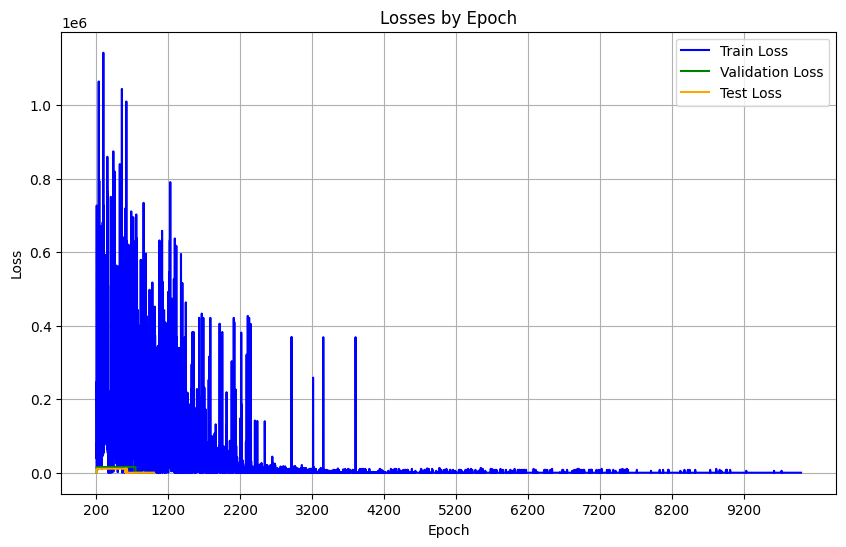

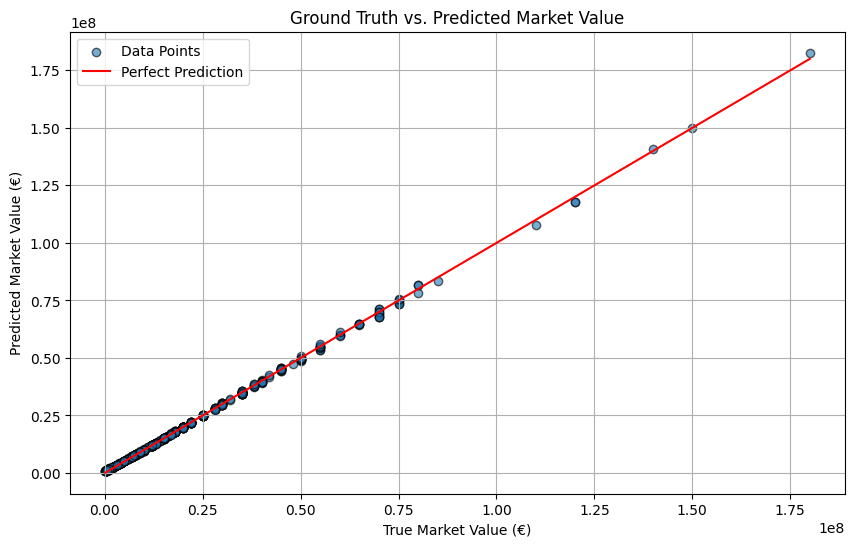

In [ ]:
import pandas as pd
import torch
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

# defines the GraphSAGE model
class GraphSAGE(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.1):
    super(GraphSAGE, self).__init__()
    torch.manual_seed(SEED)
    self.conv1 = SAGEConv(in_channels, hidden_channels)
    self.conv2 = SAGEConv(hidden_channels, out_channels)
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.dropout(x)

    x = self.conv2(x, edge_index)
    x = F.relu(x)  # Ensure non-negative outputs

    return x

# normalize input features
data.x = (data.x - data.x.mean(dim=0)) / data.x.std(dim=0)

# set up data.y for regression; initialize with zeros
data.y = torch.zeros(data.x.size(0))

# utilize Market_Value_Euro from player nodes only (team nodes will have values of zero)
for node_name, node_id in node_to_id.items():
  if node_name in player_nodes and 'Market_Value_Euro' in player_nodes[node_name]:
    market_value = player_nodes[node_name]['Market_Value_Euro']
    if market_value > 0:
      data.y[node_id] = market_value

# scale target values to [0, 1]
data.y_max = data.y.max()
data.y = data.y / data.y_max

# extract years from node names for training and testing masks
val_year = 2023
test_year = 2024
data.train_mask = torch.zeros(data.x.size(0), dtype=torch.bool)
data.val_mask = torch.zeros(data.x.size(0), dtype=torch.bool)
data.test_mask = torch.zeros(data.x.size(0), dtype=torch.bool)

for node_name, node_id in node_to_id.items():
  # checks to make sure the node is a player node with a valid Market_Value_Euro value
  if node_name in player_nodes and 'Market_Value_Euro' in player_nodes[node_name]:
    year = int(node_name.split("_")[-1])
    # places 2023 nodes in the val set, 2024 nodes in the test set, all others in the training set
    if year < val_year:
      data.train_mask[node_id] = True
    elif year == val_year:
      data.val_mask[node_id] = True
    elif year == test_year:
      data.test_mask[node_id] = True

# MAPE implementation, which prevents exploding loss
def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-7):
  return torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# initialize the model, optimizer, and loss function
model = GraphSAGE(in_channels=data.x.size(1), hidden_channels=64, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-3)
criterion = mean_absolute_percentage_error
train_losses = []
val_losses = []
test_losses = []

# apply Xavier initialization for better weight distribution
def init_weights(m):
  if isinstance(m, SAGEConv):
    torch.nn.init.xavier_uniform_(m.lin_l.weight)
    torch.nn.init.xavier_uniform_(m.lin_r.weight)
    if m.lin_l.bias is not None:
      torch.nn.init.zeros_(m.lin_l.bias)
    if m.lin_r.bias is not None:
      torch.nn.init.zeros_(m.lin_r.bias)

model.apply(init_weights)

# implement the traning function with gradient clipping
def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index).squeeze()
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
  optimizer.step()
  train_losses.append(loss.item())
  return loss.item()

# implement the validation function
def validate():
  model.eval()
  with torch.no_grad():
    pred = model(data.x, data.edge_index).squeeze()
    val_loss = criterion(pred[data.val_mask], data.y[data.val_mask])
    val_losses.append(val_loss.item())
  return val_loss.item()

# implement the test function
def test():
  model.eval()
  with torch.no_grad():
    pred = model(data.x, data.edge_index).squeeze()
    test_loss = criterion(pred[data.test_mask], data.y[data.test_mask])
    test_losses.append(test_loss.item())
    return pred, test_loss.item()

# train the model
for epoch in range(10000):
  loss = train()
  if epoch % 10 == 0:
    val_loss = validate()
    pred, test_loss = test()
    print(f"Epoch: {epoch}, Train Loss: {loss:.4f},Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")

# convert data.y_max to a scalar
y_max_scalar = data.y_max.item()

# compare true vs. predicted Market_Value_Euro values
true_values = data.y[data.test_mask].detach().cpu().numpy().flatten() * y_max_scalar
predicted_values = pred[data.test_mask].detach().cpu().numpy().flatten() * y_max_scalar

comparison = pd.DataFrame({
    "True Market Value (€)": true_values,
    "Predicted Market Value (€)": predicted_values
})

print(comparison)

plt.figure(figsize=(10, 6))
plt.plot(range(201, len(train_losses) + 1), train_losses[200:], label="Train Loss", color="blue")
plt.plot(range(201, len(val_losses) + 1), val_losses[200:], label="Validation Loss", color="green")
plt.plot(range(201, len(test_losses) + 1), test_losses[200:], label="Test Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses by Epoch")
plt.legend()
plt.grid()
plt.xticks(ticks=range(200, len(train_losses) + 1, 1000))
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(true_values, predicted_values, alpha=0.6, edgecolors='k', label="Data Points")
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color="red", linestyle="-", label="Perfect Prediction")
plt.xlabel("True Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Ground Truth vs. Predicted Market Value")
plt.legend()
plt.grid()
plt.show()

2-layer GraphSAGE with Dropout and Neighborhood Sampling

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Epoch: 0, Train Loss: 70555615.7647, Val Loss: 82280118.6667, Test Loss: 80620248.5000
Epoch: 10, Train Loss: 1087145.0386, Val Loss: 70.3312, Test Loss: 77.8460
Epoch: 20, Train Loss: 359331.5104, Val Loss: 70.7775, Test Loss: 76.0547
Epoch: 30, Train Loss: 658028.7893, Val Loss: 67.3351, Test Loss: 72.6406
Epoch: 40, Train Loss: 1770811.4770, Val Loss: 59.3524, Test Loss: 10916.0300
Epoch: 50, Train Loss: 1095230.0980, Val Loss: 58.0645, Test Loss: 64.3008
Epoch: 60, Train Loss: 658495.6665, Val Loss: 59.2102, Test Loss: 65.3189
Epoch: 70, Train Loss: 298109.7347, Val Loss: 60.2612, Test Loss: 66.0690
Epoch: 80, Train Loss: 397035.5410, Val Loss: 55.9707, Test Loss: 61.8841
Epoch: 90, Train Loss: 652810.3250, Val Loss: 54.8840, Test Loss: 60.9248
Epoch: 100, Train Loss: 266603.2875, Val Loss: 52.0227, Test Loss: 58.4407
Epoch: 110, Train Loss: 295850.0083, Val Loss: 48.5760, Test Loss: 54.5381
Epoch: 120, Train Loss: 40619.2932, Val Loss: 46.6427, Test Loss: 53.0678
Epoch: 130, Train

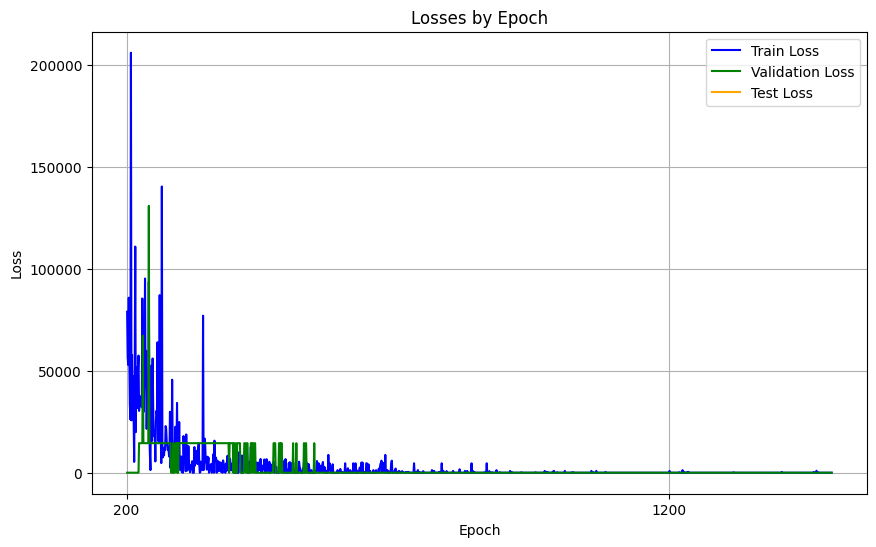

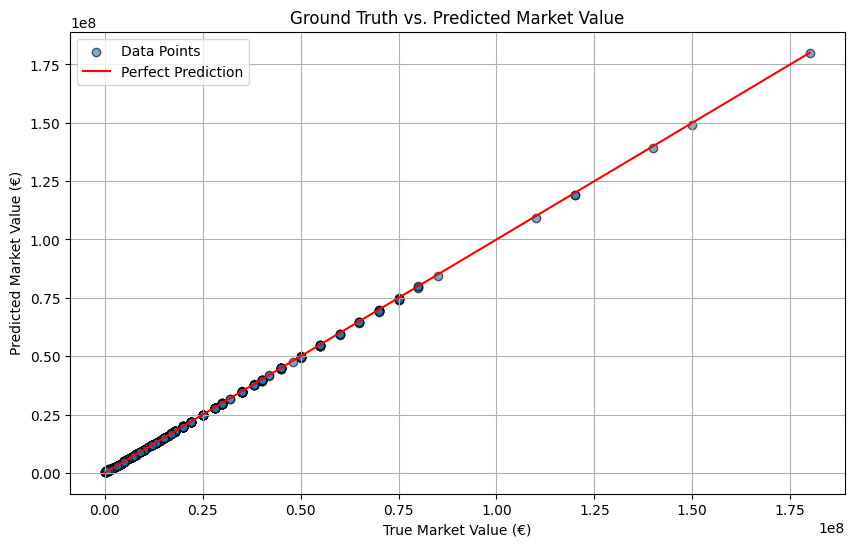

In [ ]:
import pandas as pd
import torch
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import NeighborLoader
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

# defines the GraphSAGE model
class GraphSAGE(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.1):
    super(GraphSAGE, self).__init__()
    torch.manual_seed(SEED)
    self.conv1 = SAGEConv(in_channels, hidden_channels)
    self.conv2 = SAGEConv(hidden_channels, out_channels)
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.dropout(x)

    x = self.conv2(x, edge_index)
    x = F.relu(x)  # Ensure non-negative outputs

    return x

# normalize the input features
data.x = (data.x - data.x.mean(dim=0)) / data.x.std(dim=0)

# set up data.y for regression; initialize with zeros
data.y = torch.zeros(data.x.size(0))

# utilize Market_Value_Euro from player nodes only (team nodes will have values of zero)
for node_name, node_id in node_to_id.items():
  if node_name in player_nodes and 'Market_Value_Euro' in player_nodes[node_name]:
    market_value = player_nodes[node_name]['Market_Value_Euro']
    if market_value > 0:
      data.y[node_id] = market_value

# scale target values to [0, 1]
data.y_max = data.y.max()
data.y = data.y / data.y_max

# extract years from node names for training, validation, and testing masks
val_year = 2023
test_year = 2024
data.train_mask = torch.zeros(data.x.size(0), dtype=torch.bool)
data.val_mask = torch.zeros(data.x.size(0), dtype=torch.bool)
data.test_mask = torch.zeros(data.x.size(0), dtype=torch.bool)

for node_name, node_id in node_to_id.items():
  if node_name in player_nodes and 'Market_Value_Euro' in player_nodes[node_name]:
    year = int(node_name.split("_")[-1])
    if year < val_year:
      data.train_mask[node_id] = True
    elif year == val_year:
      data.val_mask[node_id] = True
    elif year == test_year:
      data.test_mask[node_id] = True

# define NeighborLoader for sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[10, 5],  # sample 10 neighbors at layer 1, 5 at layer 2
    batch_size=64,           # process 64 nodes per batch
    input_nodes=data.train_mask
)

val_loader = NeighborLoader(
    data,
    num_neighbors=[10, 5],
    batch_size=64,
    input_nodes=data.val_mask
)

test_loader = NeighborLoader(
    data,
    num_neighbors=[10, 5],
    batch_size=64,
    input_nodes=data.test_mask
)

# MAPE implementation
def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-7):
  return torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# initialize the model, optimizer, and loss function
model = GraphSAGE(in_channels=data.x.size(1), hidden_channels=64, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-3)
criterion = mean_absolute_percentage_error
train_losses = []
val_losses = []
test_losses = []

# apply Xavier initialization
def init_weights(m):
  if isinstance(m, SAGEConv):
    torch.nn.init.xavier_uniform_(m.lin_l.weight)
    torch.nn.init.xavier_uniform_(m.lin_r.weight)
    if m.lin_l.bias is not None:
      torch.nn.init.zeros_(m.lin_l.bias)
    if m.lin_r.bias is not None:
      torch.nn.init.zeros_(m.lin_r.bias)

model.apply(init_weights)

# training loop with neighbor sampling
def train():
  model.train()
  total_loss = 0
  for batch in train_loader:
    optimizer.zero_grad()
    out = model(batch.x, batch.edge_index).squeeze()
    loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    total_loss += loss.item()
  train_losses.append(total_loss / len(train_loader))

# validation loop
def validate():
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for batch in val_loader:
      out = model(batch.x, batch.edge_index).squeeze()
      val_loss = criterion(out[batch.val_mask], batch.y[batch.val_mask])
      total_loss += val_loss.item()
  val_losses.append(total_loss / len(val_loader))

# test loop
def test():
  model.eval()
  total_loss = 0
  all_preds = []
  with torch.no_grad():
      for batch in test_loader:
          out = model(batch.x, batch.edge_index).squeeze()
          test_loss = criterion(out[batch.test_mask], batch.y[batch.test_mask])
          total_loss += test_loss.item()
          all_preds.append(out[batch.test_mask].detach().cpu())
  test_losses.append(total_loss / len(test_loader))
  return torch.cat(all_preds, dim=0)

# train the model
for epoch in range(1500):
  train()
  validate()
  if epoch % 10 == 0:
      preds = test()
      print(f"Epoch: {epoch}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# rescale predictions to original range
y_max_scalar = data.y_max.item()
true_values = data.y[data.test_mask].detach().cpu().numpy().flatten() * y_max_scalar
predicted_values = preds.numpy().flatten() * y_max_scalar

# compare true vs. predicted values
comparison = pd.DataFrame({
    "True Market Value (€)": true_values,
    "Predicted Market Value (€)": predicted_values
})

print(comparison)

plt.figure(figsize=(10, 6))
plt.plot(range(201, len(train_losses) + 1), train_losses[200:], label="Train Loss", color="blue")
plt.plot(range(201, len(val_losses) + 1), val_losses[200:], label="Validation Loss", color="green")
plt.plot(range(201, len(test_losses) + 1), test_losses[200:], label="Test Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses by Epoch")
plt.legend()
plt.grid()
plt.xticks(ticks=range(200, len(train_losses) + 1, 1000))
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(true_values, predicted_values, alpha=0.6, edgecolors='k', label="Data Points")
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color="red", linestyle="-", label="Perfect Prediction")
plt.xlabel("True Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Ground Truth vs. Predicted Market Value")
plt.legend()
plt.grid()
plt.show()